In [125]:
# generic imports
import os
import time
import pickle
from pyprojroot import here
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
# jax import
import jax
import jax.numpy as jnp
from jax import random
# numpyro import
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
# arviz import
import arviz as az
# local imports
# Add code src directory to sys.path
sys.path.append(str(here() / "src"))
from loader_jkt import load_data
from gp import gp_aggr, gp_aggr_count
from kernels import exp_sq_kernel
from plotting import plot_incidence_map, plot_process
# config
jax.config.update('jax_platform_name', 'cpu');
print(f'We are using {jax.devices()} under the hood.')
print(f'The default path is {here()}')

We are using [CpuDevice(id=0)] under the hood.
The default path is c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP


In [126]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


In [127]:
# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2020
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population


Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2020



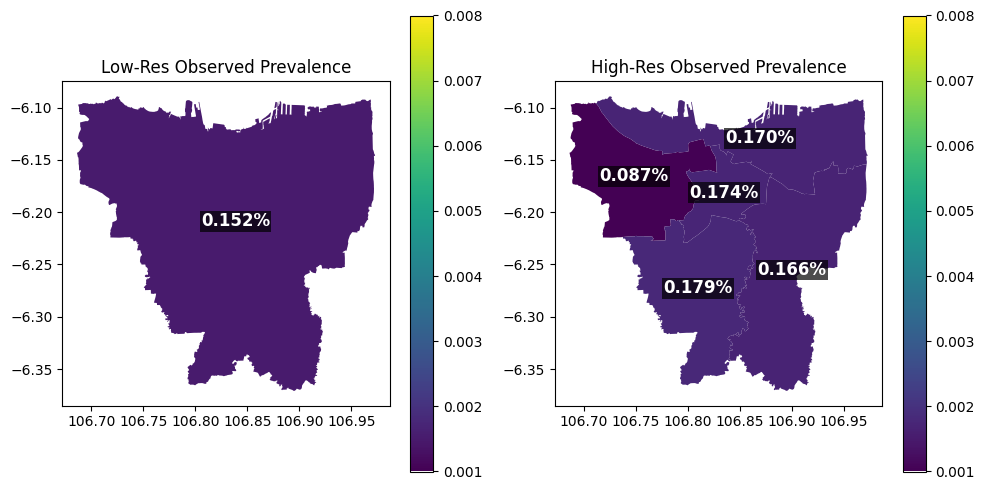

In [128]:
# Plot data using the reusable function
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot low resolution data
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")

# Plot high resolution data
plot_incidence_map(df_hi, ax = ax[1], title = "High-Res Observed Prevalence")

plt.tight_layout()
plt.show()


In [129]:
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [130]:
# Lets look at agg_gp by drawing samples from it
# Define the configuration
config = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(4, 1),
    'kernel_var': dist.LogNormal(0, 0.1),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

# Draw samples from the prior
prior_samples = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config
)

In [96]:
# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

In [97]:
# Plot the process
plot_process(prior_samples_arviz.prior.pred_cases.values)

In [131]:
#plot gp_aggr priors directly for the one using config GP hyperparameters
gp_predictive = Predictive(gp_aggr, num_samples = 5)
gp_draws = gp_predictive(random.PRNGKey(6), config)["gp_aggr"]
plot_process(jnp.expand_dims(gp_draws, axis = 0))

In [133]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [134]:
# Draw samples from the prior
prior_gp_count = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config_count
)
# arviz inference object count model prior
# transform prior samples to arviz inference object
prior_gp_count_arviz = az.from_numpyro(prior=prior_gp_count)

In [135]:
# Plot the process
plot_process(prior_gp_count_arviz.prior.pred_cases.values)

In [136]:
#plot gp_aggr priors directly for the one using config_count GP hyperparameters
gp_draws = gp_predictive(random.PRNGKey(6), config_count)["gp_aggr"]
plot_process(jnp.expand_dims(gp_draws, axis = 0))

In [137]:
# Run MCMC
# Base seed for reproducibility
base_seed = 30  # Keep this fixed for full replicability
# MCMC settings
n_warm = 2000
n_samples = 2000
rng = jax.random.PRNGKey(base_seed)

# Define the model
model = gp_aggr_count

# Define the sampler
sampler = NUTS(model, target_accept_prob=0.9, max_tree_depth=20)
mcmc = MCMC(sampler, # change for later run to target_accept_prob = 0.99 and max_tree_depth = 20
            num_warmup=n_warm,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            progress_bar=True
            )
start = time.time()
mcmc.run(rng, config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")
# %%

sample: 100%|██████████| 4000/4000 [21:04<00:00,  3.16it/s] 

Time taken to run MCMC: 21 minutes


In [138]:
#save the mcmc from gp for jkt for each specific year (change the year manually)

# Define the path where you want to save the MCMC files
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # this assumes you are in the 'src' folder
model_weights_dir = os.path.join(base_dir, 'model weights', 'aggGP')

# Make sure the directory exists, otherwise create it
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# Define the file path where to save the MCMC object
file_path = os.path.join(model_weights_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_targetprob0.9.pkl")
    

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2020 saved successfully at c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\model weights\aggGP\mcmc_jkt_2020_21min_targetprob0.9.pkl.


# MCMC Inference

In [139]:
#load the mcmc data u want
with open("../model weights/aggGP/mcmc_jkt_2020_21min_targetprob0.9.pkl", "rb") as f_1:
    mcmc = pickle.load(f_1)

In [140]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [141]:
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.92     10.36    100.15     83.61    116.96    879.51      1.00
          b_hdi     -0.06      0.99     -0.06     -1.70      1.59    541.05      1.01
  b_pop_density      0.01      1.03     -0.01     -1.64      1.66    918.56      1.01
        b_urban     -0.01      0.97      0.02     -1.64      1.54    470.86      1.02
  kernel_length      0.51      0.30      0.43      0.17      0.85    617.60      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    928.34      1.00
       log_f[0]      2.95      0.64      2.95      1.92      4.06      5.70      1.28
       log_f[1]      2.94      0.63      2.94      1.90      4.02      5.39      1.30
       log_f[2]      2.94      0.63      2.94      1.83      3.95      5.29      1.31
       log_f[3]      2.94      0.64      2.95      1.92      4.05      5.13      1.32
       log_f[4]      2.94      0.64      2.93      1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1386.081,815.116,207.831,2985.267,255.718,89.037,10.0,81.0,1.34
pred_cases[1],324.640,204.942,-36.959,706.395,55.818,13.224,14.0,68.0,1.21
pred_cases[2],214.098,151.321,-38.805,494.813,31.638,5.712,24.0,244.0,1.12
pred_cases[3],366.188,225.936,-27.991,779.215,64.028,17.738,13.0,69.0,1.23
pred_cases[4],453.377,272.409,-27.754,938.519,80.381,24.152,11.0,87.0,1.27
pred_cases[5],412.871,246.937,-20.319,856.014,69.928,20.094,12.0,89.0,1.25
lp[0],1386.700,813.221,199.640,2973.630,255.480,88.932,10.0,82.0,1.35
lp[1],324.349,196.202,0.000,662.367,54.825,13.875,13.0,68.0,1.23
lp[2],213.011,141.678,0.000,447.342,31.803,5.705,20.0,255.0,1.13
lp[3],366.878,219.659,0.000,744.239,64.479,18.438,12.0,66.0,1.25


In [142]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 5
Average ESS for all aggGPE-low effects : 5
Max r_hat for all aggGP-low : 1.309999942779541
Average ESS for all aggGP-high effects : 5
Max r_hat for all aggGP-high : 1.2999999523162842


In [143]:
# stacked data
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0,1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population
# %%

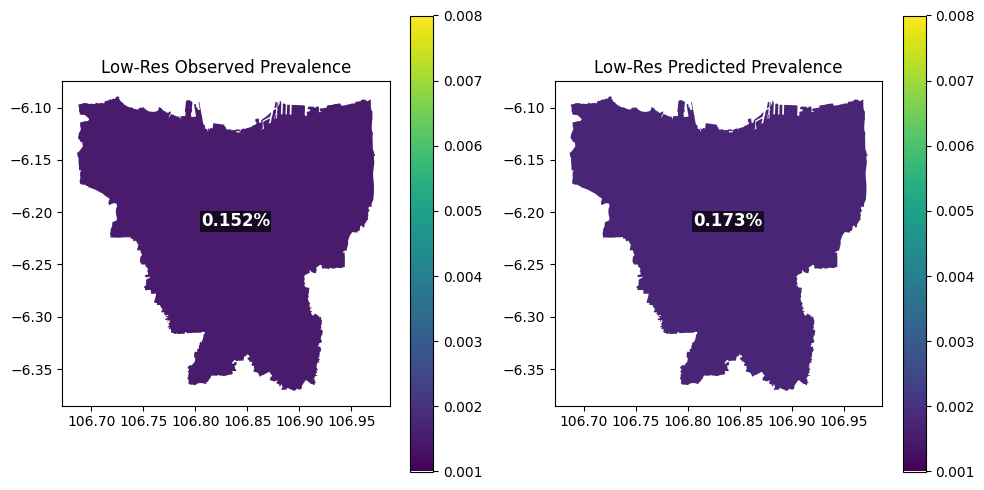

In [144]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

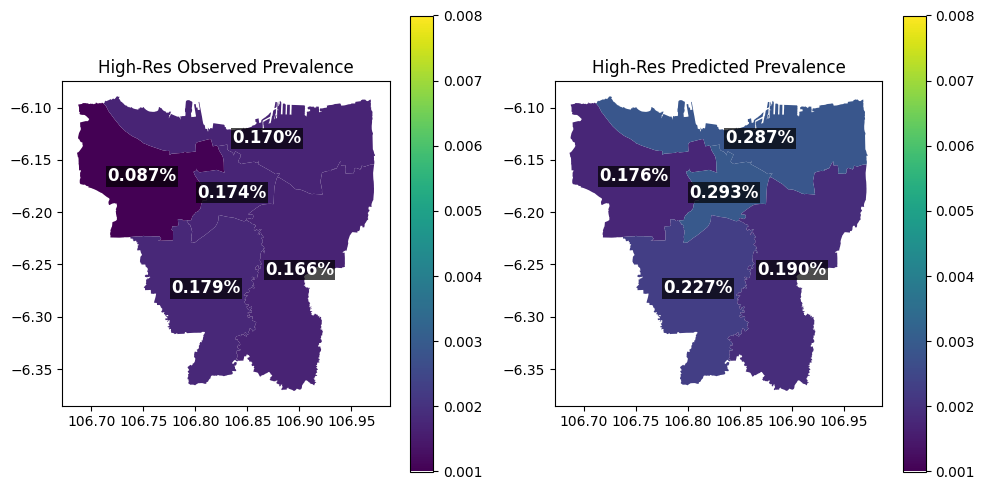

In [145]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [146]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2020.csv")

In [55]:
n_lo = 1
n_hi = 5

# Find Optimal Target Prob Acceptance! - tested on 2021 data!

In [56]:
with open("../model weights/aggGP/mcmc_jkt_2021_30min_targetprob0.9_notconvergedyet.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggGP/mcmc_jkt_2021_36min_targetprob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggGP/mcmc_jkt_2021_20min_targetprob0.8.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

### MCMC 1 prob = 0.9

In [57]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [58]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.97     10.19     99.98     83.26    116.48   1976.06      1.00
          b_hdi     -0.03      1.00     -0.05     -1.71      1.62   1344.53      1.00
  b_pop_density      0.01      1.00      0.00     -1.58      1.67   1755.23      1.00
        b_urban     -0.02      1.02     -0.01     -1.71      1.63   1149.78      1.00
  kernel_length      0.48      0.26      0.42      0.17      0.81    721.77      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1512.52      1.00
       log_f[0]      3.02      0.62      3.06      1.97      4.00     56.82      1.10
       log_f[1]      3.03      0.62      3.04      2.04      4.07     57.28      1.10
       log_f[2]      3.02      0.62      3.04      2.02      4.04     62.21      1.09
       log_f[3]      3.03      0.61      3.03      2.11      4.11     70.60      1.09
       log_f[4]      3.03      0.60      3.03      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1493.302,845.855,249.292,2969.176,125.396,58.622,30.0,266.0,1.10
pred_cases[1],342.481,197.056,-16.604,689.856,18.968,8.177,89.0,397.0,1.04
pred_cases[2],222.625,151.330,-43.800,492.867,7.035,3.533,468.0,1276.0,1.02
pred_cases[3],394.417,227.802,-10.304,787.173,31.207,10.146,50.0,442.0,1.07
pred_cases[4],487.592,271.625,26.545,961.755,37.983,14.987,37.0,383.0,1.08
pred_cases[5],436.706,237.654,19.201,863.769,23.662,12.980,77.0,287.0,1.05
lp[0],1493.107,843.165,270.781,2969.545,125.339,58.621,30.0,263.0,1.10
lp[1],342.326,189.805,0.000,646.978,18.392,8.391,86.0,390.0,1.05
lp[2],222.352,140.765,0.000,451.726,6.906,3.457,427.0,1035.0,1.02
lp[3],393.686,220.402,0.000,747.258,31.054,10.274,47.0,447.0,1.07


In [59]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 98
Average ESS for all aggGP-low effects : 86
Max r_hat for all aggGP-low : 1.0700000524520874
Average ESS for all aggGP-high effects : 100
Max r_hat for all aggGP-high : 1.0800000429153442


### MCMC 1 prob = 0.95

In [60]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [61]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.29     10.21    100.53     84.42    117.67   1306.98      1.00
          b_hdi      0.00      0.99      0.01     -1.55      1.71    947.90      1.00
  b_pop_density     -0.02      1.00     -0.02     -1.66      1.58   1272.70      1.01
        b_urban      0.05      0.98      0.07     -1.62      1.58    667.46      1.01
  kernel_length      0.51      0.30      0.43      0.17      0.87    666.36      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1422.40      1.00
       log_f[0]      3.13      0.56      3.16      2.27      4.07     31.57      1.08
       log_f[1]      3.13      0.56      3.16      2.29      4.07     30.52      1.09
       log_f[2]      3.13      0.56      3.16      2.28      4.06     25.98      1.09
       log_f[3]      3.13      0.55      3.16      2.32      4.08     26.31      1.09
       log_f[4]      3.13      0.56      3.18      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1606.996,747.824,347.972,2918.629,144.559,81.702,27.0,81.0,1.12
pred_cases[1],370.622,186.748,5.804,708.615,28.151,7.510,45.0,178.0,1.07
pred_cases[2],240.195,144.456,-21.849,502.869,12.199,3.642,146.0,546.0,1.04
pred_cases[3],424.293,210.135,53.831,832.735,32.371,10.314,42.0,155.0,1.07
pred_cases[4],527.778,250.708,74.853,976.710,43.790,18.801,32.0,148.0,1.10
pred_cases[5],473.450,223.731,78.877,894.529,40.330,16.445,31.0,134.0,1.10
lp[0],1607.473,747.136,399.101,2966.069,145.403,81.911,26.0,74.0,1.12
lp[1],370.078,178.291,0.000,660.106,27.869,8.052,42.0,162.0,1.07
lp[2],240.757,136.016,0.000,460.095,14.780,3.690,86.0,578.0,1.04
lp[3],424.253,203.090,0.000,740.326,32.718,10.586,38.0,156.0,1.08


In [62]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 33
Average ESS for all aggGP-low effects : 31
Max r_hat for all aggGP-low : 1.1200000047683716
Average ESS for all aggGP-high effects : 34
Max r_hat for all aggGP-high : 1.1200000047683716


### MCMC 1 prob = 0.8

In [63]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [64]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     96.05     10.84     96.80     82.73    113.75      4.95      1.33
          b_hdi     -0.52      1.10     -0.65     -2.57      1.16      8.10      1.40
  b_pop_density     -0.12      0.92     -0.27     -1.44      1.37     10.13      1.17
        b_urban     -0.07      0.81      0.08     -1.39      1.35    205.38      1.02
  kernel_length      0.47      0.26      0.37      0.18      0.74     16.23      1.11
     kernel_var      0.38      0.02      0.38      0.35      0.41     12.44      1.24
       log_f[0]      3.17      0.51      3.07      2.43      4.06      7.08      1.24
       log_f[1]      3.15      0.55      3.07      2.42      4.05      4.91      1.36
       log_f[2]      3.20      0.50      3.08      2.41      4.03      6.67      1.26
       log_f[3]      3.08      0.55      3.10      2.39      3.98      4.17      1.43
       log_f[4]      3.12      0.54      3.10      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1486.167,902.777,494.899,2891.573,376.801,126.621,6.0,9.0,1.90
pred_cases[1],300.384,192.598,51.634,692.819,62.300,16.488,9.0,118.0,1.35
pred_cases[2],174.343,140.658,4.630,474.317,40.351,11.815,14.0,116.0,1.21
pred_cases[3],357.517,215.445,110.319,807.627,75.649,22.361,8.0,64.0,1.42
pred_cases[4],455.075,273.392,146.976,959.510,105.140,27.131,7.0,52.0,1.52
pred_cases[5],399.560,239.467,114.207,843.459,88.803,24.244,7.0,11.0,1.50
lp[0],1485.655,902.034,459.838,2830.171,376.775,127.000,6.0,11.0,1.91
lp[1],301.359,185.584,66.461,674.108,62.248,16.500,9.0,127.0,1.38
lp[2],175.546,134.058,0.000,416.260,40.942,9.869,12.0,130.0,1.24
lp[3],357.213,211.020,106.396,784.001,75.548,22.093,8.0,69.0,1.44


In [65]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 3
Average ESS for all aggGP-low effects : 3
Max r_hat for all aggGP-low : 1.8300000429153442
Average ESS for all aggGP-high effects : 3
Max r_hat for all aggGP-high : 1.8300000429153442
